# YOLOv5 Object Detection Model 

The code below was heavily influenced by the **[YOLOv5 🚀 tutorial notebook](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=zR9ZbuQCH7FX)** created by **Ultralytics**. Direct lines were borrowed in order to build, train, and test object detection models.


# 0. Setup

*    Mount Google Drive to Google Colab for easy file access.
*   Clone repo, install dependencies and check PyTorch and GPU.
*   Pip install cython (for performance reasons)
*   Pip install yaml



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# % denotes shell command
# update path for yolov5 clone

main_path = '/content/drive/MyDrive/researchpaper2023/' 
project_folder = 'YOLOv5_v00/' # create file in directory

%cd {main_path}{project_folder}
!git clone https://github.com/ultralytics/yolov5   # clone and create unique folder
%cd {main_path}{project_folder}'yolov5'
%pip install -qr requirements.txt  # install

/content/drive/MyDrive/researchpaper2023/YOLOv5_v00
Cloning into 'yolov5'...
remote: Enumerating objects: 14889, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 14889 (delta 1), reused 2 (delta 0), pack-reused 14882
Receiving objects: 100% (14889/14889), 13.86 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (10247/10247), done.
/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5
     |████████████████████████████████| 182 kB 20.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 61.5 MB/s 


In [3]:
%cd {main_path}{project_folder}'yolov5'

import torch
import utils
display = utils.notebook_init()  # check

YOLOv5 🚀 v7.0-49-g3c1afd9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.0/78.2 GB disk)


# 1. Data Preparation

For this project, we are going to use a synthetic dataset generated using Unity data generation software. In order for a dataset to be digested in YOLOv5, it must follow a specific format.

In [12]:
# manually upload data in your project folder and denote images and mask file paths
# manually create 'labels' folder

dataset_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/'
images_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/images/'
mask_path = ''
labels_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/labels'

# dataset_public_path = '/content/drive/MyDrive/w207_Fall2022/dataset/publicdomain_images'
images_public_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/images/'
# mask_public_path = ''
# labels_public_path = '/content/drive/MyDrive/w207_Fall2022/dataset/publicdomain_images/labels'

%cd {main_path}{project_folder}

/content/drive/MyDrive/researchpaper2023/YOLOv5_v00


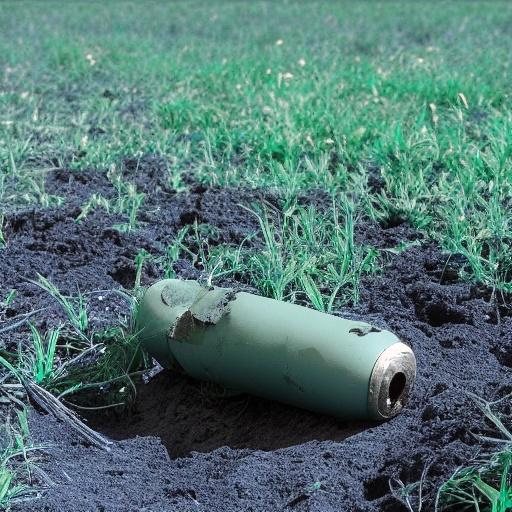

In [6]:
example_image_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/images/image_An-unexploded-9N235-submunition-in-the-ground0_jpg.rf.3d876e402215f31185689a92c919e698.jpg'
from PIL import Image
Image.open(example_image_path) # insert example of image

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

# manualy create "labels" folder

# create a class that will 
  # 1) generate a single .txt file with the file paths for all images
  # 2) generate individual .txt files with the label details for each image
# each .txt file will have a line per object in the label file (i.e., if your image has 2 objects, there will be two lines in your label .txt file)
# each line of the "label" file has the following format: [object_category, x_center, y_center, object_width, object_height]
# name this file your "label" file

class Greentea(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images")))) # accessing image file
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask_content")))) # accessing masks file

    def generateimgfile(self):
      # load image paths 
        file_name_img = 'greentea' + '_imgfile' + '.txt'
        with open(dataset_path + file_name_img, 'w') as imgfile: # save files in image folder
          for idx, image_detail in enumerate(self.imgs):
            img_path = os.path.join(self.root, "images", self.imgs[idx])
            imgfile.write(img_path)
            imgfile.write('\n')
        imgfile.close()

    def generatelabelsfile(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask_content", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        
        mask_img = Image.open(mask_path)
        
        mask = np.array(mask_img)
        mask[:, :, 0] = mask[:, :, 0] + mask[:, :, 1] * 256 + mask[:, :, 2] * 256 * 256
        mask = np.delete(mask, [1, 2, 3], axis=2).reshape(mask.shape[0], mask.shape[1])

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)

        boxes = []

        file_name_label = str(self.imgs[idx][:-4]) + '.txt'
        with open(labels_path + str(file_name_label), 'w') as f: # save files in 'labels' folder
            img_height = mask_img.height
            img_width = mask_img.width
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])
                
                width = abs(xmin - xmax)
                height = abs(ymin - ymax)
                x_center = xmin + width/2
                y_center = ymin + height/2
                f.write('0' + ' ' + str(x_center/img_width) + ' ' + str(y_center/img_height) + ' ' + str(width/img_width) + ' ' + str(height/img_height) + '\n') # object_class is 0
    def __len__(self):
        return len(self.imgs)

In [ ]:
# instantiate for train / validation data
dataset = Greentea(dataset_path)

In [ ]:
# create class that will generate a single .txt file with the file paths for all public domain test images

class Greentea_public(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images")))) # accessing image file
        # self.masks = list(sorted(os.listdir(os.path.join(root, "mask_content")))) # there is no mask content provided by Roboflow output, so this line is omitted

    def generateimgfile(self):
      # load image paths 
        file_name_img = 'public_test_greentea' + '_imgfile' + '.txt'
        with open(dataset_path + file_name_img, 'w') as imgfile: # save files in image folder
          for idx, image_detail in enumerate(self.imgs):
            img_path = os.path.join(self.root, "images", self.imgs[idx])
            imgfile.write(img_path)
            imgfile.write('\n')
        imgfile.close()



In [ ]:
# instantiate for public domain test dataset
dataset_public = Greentea_public(dataset_public_path)

Generate your img file and verify that your img file looks like the example below. All label files should be placed in a 'images' folder.

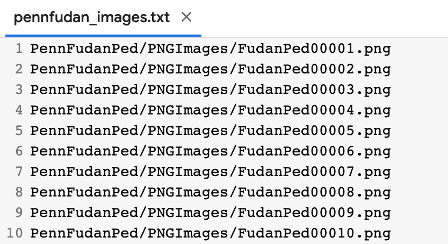

In [ ]:
# prep your data by creating a single .txt file that contains a list of file paths for each image 
# name this file your "images" file
# print your .txt to verify it is in the correct format
# img files should be saved in the "images" folder

dataset.generateimgfile()

In [ ]:
# create a single txt file with a list of file paths for each public test image 

dataset_public.generateimgfile()

In [ ]:
# update image file path for train / validate data

imagetxt_path = '/content/drive/MyDrive/w207_Fall2022/dataset/greentea_imgfile.txt'
f_img = open(imagetxt_path, 'r')
img_file_contents = f_img.readlines()

i = 0 
while i < 5:
  print(img_file_contents[i])
  print('\n')
  i += 1

/content/drive/MyDrive/w207_Fall2022/dataset/images/rgb_10.png



/content/drive/MyDrive/w207_Fall2022/dataset/images/rgb_100.png



/content/drive/MyDrive/w207_Fall2022/dataset/images/rgb_1000.png



/content/drive/MyDrive/w207_Fall2022/dataset/images/rgb_1001.png



/content/drive/MyDrive/w207_Fall2022/dataset/images/rgb_1002.png





Generate your label file and verify that your label file looks like the example below. All label files should be placed in a 'labels' folder.

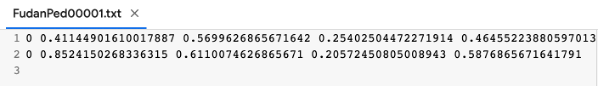

In [ ]:

# generate label files for each image in 'images' folder
# label files should be saved in the "labels" folder
for i, name in enumerate(dataset.imgs):
  dataset.generatelabelsfile(i)

In [ ]:
import glob

%cd {labels_path}
filelist = glob.glob("*.txt")  # Get all .txt files in the current folder
f = open(filelist[0], 'r')
file_contents = f.read()
print(file_contents)

/content/drive/MyDrive/w207_Fall2022/dataset/labels
0 0.31328125 0.1109375 0.1078125 0.221875



In [ ]:
# split your image .txt file into train, validation, and test files 
# imgtxtfile_path is the path directly to the images .txt file
# nc = number of classes
# names = names of classes []
# create yaml file with image split sets

import yaml

def image_file_split(imgtxtfile_path, train_percentage, val_percentage, nc, names):
  fp = open(imgtxtfile_path, 'r')
  all_lines = fp.readlines()
  total_count = len(all_lines)
  train_count = round(total_count * train_percentage)
  val_count = round(total_count * val_percentage)
  
  file_count = 0
  with open(dataset_path + 'imgtrain' + '_' + str(train_percentage)+ '.txt', 'w') as f_train: 
    while file_count < train_count:
      f_train.write(all_lines[file_count])
      file_count +=1
  
  with open(dataset_path + 'imgval' + '_' + str(val_percentage)+ '.txt', 'w') as f_val: 
    while file_count < train_count+val_count:
      f_val.write(all_lines[file_count])
      file_count +=1

  with open(dataset_path + 'imgtest' + '_' + str(train_percentage)+ '_' + str(val_percentage)+ '.txt', 'w') as f_test: 
    while file_count < total_count:
      f_test.write(all_lines[file_count])
      file_count +=1

  dict_file = {'path' : dataset_path,
              'train' : 'imgtrain' + '_' + str(train_percentage)+ '.txt', 
              'val' : 'imgval'+ '_' + str(val_percentage)+ '.txt', 
              'test' : 'imgtest'+ '_' + str(train_percentage)+ '_' + str(val_percentage)+ '.txt',
              'nc' : nc,
              'names' : [str(names)]}

  title = 'train'+ '_' + str(train_percentage)+ 'val'+ '_' + str(val_percentage) + '.yaml'

  with open(dataset_path + str(title), 'w') as file:
      documents = yaml.dump(dict_file, file, default_flow_style=None)

# 1. Model without Evolve Hyperparameter Tuning on Public Dataset

In [ ]:
# execute
image_file_split(imagetxt_path, .8, .2, 1, 'greentea_itoen')

The .yaml file should look like the example below.

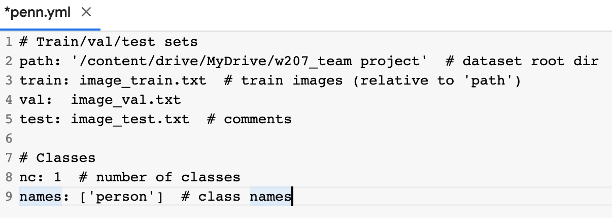

# 2. [Train, Validate, Hyperparameter Tuning](https://docs.ultralytics.com/tutorials/hyperparameter-evolution/)

In [9]:
# manually update yaml file with public domain test dataset as 'test'

yaml_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/data.yaml'

# for our first run, we are going to train the model without any evolve function.

%cd {main_path}{project_folder}'yolov5'

!python train.py --epochs 5 --data {yaml_path} --weights yolov5s.pt --cache 

/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-49-g3c1afd9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1

# 3. Test Model

Next we will test the tuned model against our test dataset.

In [11]:
# Run YOLOv5 on imgfile_test
# replace weights with best.pt file from trained model above

bestweights_path = '/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5/runs/train/exp3/weights/best.pt'

!python val.py --weights {bestweights_path} --data {yaml_path} --img 512 --iou 0.65 --task test

val: data=/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/data.yaml, weights=['/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=512, conf_thres=0.001, iou_thres=0.65, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-49-g3c1afd9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/train/labels.cache... 5 images, 1 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 1/1 [00:00<00:00,  3.33it/s]
                   all          5      

# 4. Run Inference  With Tuned Weights

In [16]:
# replace weights with best.pt file from tuned train model
%cd {main_path}{project_folder}'yolov5'
!python detect.py --weights {bestweights_path} --img 512 --conf 0.25 --source {images_public_path}

/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5
detect: weights=['/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5/runs/train/exp3/weights/best.pt'], source=/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/images/, data=data/coco128.yaml, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-49-g3c1afd9 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /content/drive/MyDrive/researchpaper2023/YOLOv5_v00/generated_data_yolov5/images/image_An-unexploded-9N235-submunition-in-the-ground0_jpg.rf.3d876e402215f31

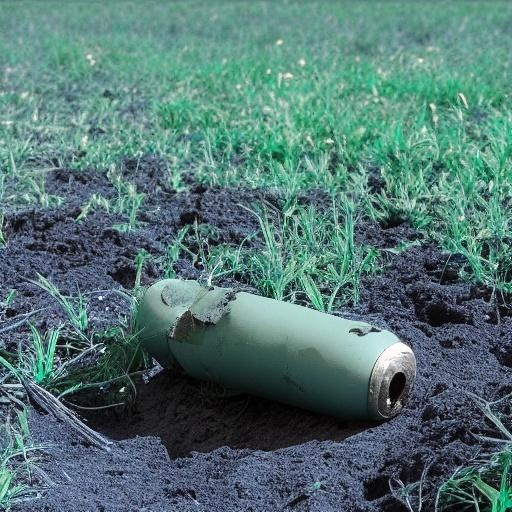

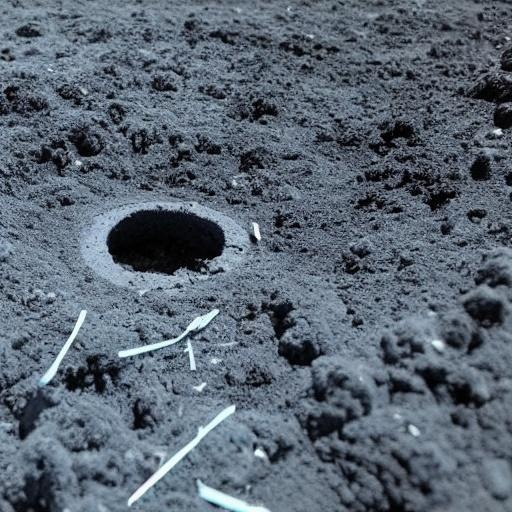

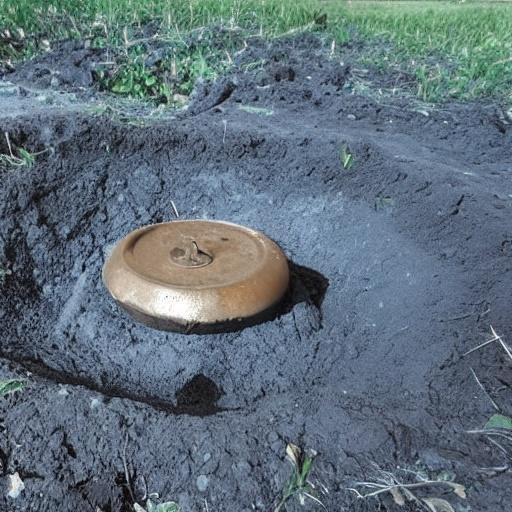

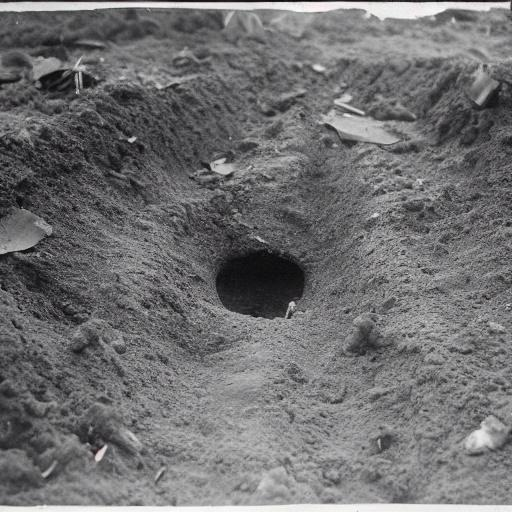

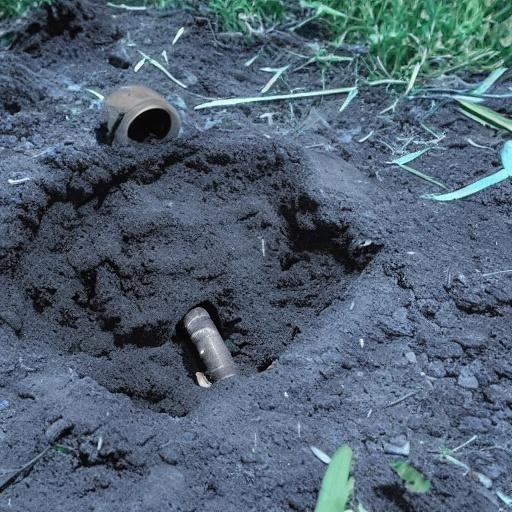

In [17]:
#display inference on the 5 test images

import glob
from IPython.display import Image, display

count = 0
for imageName in glob.glob('/content/drive/MyDrive/researchpaper2023/YOLOv5_v00/yolov5/runs/detect/exp/*.jpg'): 
    display(Image(filename=imageName))
    print("\n")
    count += 1
    if count > 100:
      break